In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import time
import os
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import cv2
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import threading


cudnn.benchmark = True

In [8]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [11]:
data_dir = './data'
class_names = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

[ WARN:9@373.750] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


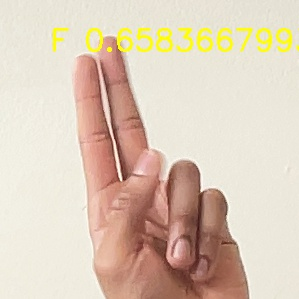

In [17]:
#https://abauville.medium.com/display-your-live-webcam-feed-in-a-jupyter-notebook-using-opencv-d01eb75921d1

chosen_model = "inception"

model = models.inception_v3(pretrained=True)
model.aux_logits=False
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(os.path.abspath(f"./models/{chosen_model}")))
model.eval()

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        
#         print(frame.shape)
        
        # crop and resize the frame
        crop_width, crop_height = 299, 299  # Adjust these values as per your requirements

        # Get the dimensions of the image
        height, width = frame.shape[:2]

        # Calculate coordinates for the crop
        start_x = (width - crop_width) // 2
        start_y = (height - crop_height) // 2

        # Crop the image
        cropped_image = frame[start_y:start_y + crop_height, start_x:start_x + crop_width]
        
        frame = cv2.resize(frame, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    
        
        frame = cropped_image.astype(np.float32)

        new_frame = data_transforms(frame / 255).unsqueeze(0)

        with torch.no_grad():
            pred = class_names[torch.argmax(model(new_frame))] + ' ' + str(torch.max(nn.Softmax()(model(new_frame))).item())
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(frame,  
                pred,  
                (50, 50),  
                font, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
        
        _, frame = cv2.imencode('.jpeg', frame)
        
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()